# Advanced Machine Learning with Hyperparameter Sensitivity Analysis using Optuna

Dataset: Wine Quality Classification

Author: **JAMILA**
-------------------------------------------------------------------------------------------------
Description: Comprehensive ML pipeline with hyperparameter optimization and sensitivity analysis
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------

**Pipeline steps:**

1. Load data → train/test split (stratified) → scale features (fit on train, transform train/test).

2. Optuna *(TPE sampler - Tree-structured Parzen Estimator)* searches good hyperparameters per model (separate study per model).

3. Retrain each model on the full training set with the best found params.

4. Evaluate on the test set; compare accuracy and macro-F1.

5. Do a one-at-a-time sensitivity analysis around the best params to see which knobs actually matter.

6. Save trained models, studies, and scaler with joblib.

# Step 1
Loading necessary Libs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice
import joblib
import warnings
warnings.filterwarnings('ignore')

# Step 2
Defining ML-based Functions

*Models tuned:* RandomForest, GradientBoosting, SVM, LogisticRegression.

In [11]:
class MLPipeline:    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.best_models = {}
        self.study_results = {}
        self.sensitivity_results = {}
        self.X_train_shape = [] 
        self.X_test_shape = []
        self.y_train_shape = []
        self.y_test_shepe = []
        
    def load_and_prepare_data(self):
        wine = load_wine()
        X = pd.DataFrame(wine.data, columns=wine.feature_names)
        y = wine.target
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=self.random_state, stratify=y
        )
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        self.X_train, self.X_test = X_train_scaled, X_test_scaled
        self.y_train, self.y_test = y_train, y_test
        self.feature_names = X.columns.tolist()
        self.X_train_shape.append(self.X_train.shape) 
        self.X_test_shape.append(self.X_test.shape) 
        self.y_train_shape.append(self.y_train.shape)  
        self.y_test_shepe.append(self.y_test.shape) 
        return X_train_scaled, X_test_scaled, y_train, y_test
    
    def _shape_dataset(self):
        print(f"X train shape: {self.X_train_shape[0]}")
        print(f"X test shape: {self.X_test_shape[0]}")
        print(f"Y train shape: {self.y_train_shape[0]}")
        print(f"Y test shape: {self.y_test_shepe[0]}")
        return
    
    def objective_rf(self, trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'random_state': self.random_state
        }
        
        model = RandomForestClassifier(**params)
        cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=5, scoring='f1_macro')
        return cv_scores.mean()
    
    def objective_gb(self, trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.8, 1.0),
            'random_state': self.random_state
        }
        
        model = GradientBoostingClassifier(**params)
        cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=5, scoring='f1_macro')
        return cv_scores.mean()
    
    def objective_svm(self, trial):
        params = {
            'C': trial.suggest_float('C', 0.1, 100, log=True),
            'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
            'kernel': trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid']),
            'random_state': self.random_state
        }
        if params['kernel'] == 'poly':
            params['degree'] = trial.suggest_int('degree', 2, 5)
        model = SVC(**params)
        cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=5, scoring='f1_macro')
        return cv_scores.mean()
    
    def objective_lr(self, trial):
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
        params = {
            'C': trial.suggest_float('C', 0.001, 100, log=True),
            'penalty': penalty,
            'max_iter': trial.suggest_int('max_iter', 100, 1000),
            'solver': 'saga', 
            'random_state': self.random_state
        }
        if penalty == 'elasticnet':
            params['l1_ratio'] = trial.suggest_float('l1_ratio', 0.0, 1.0)
        model = LogisticRegression(**params)
        cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=5, scoring='f1_macro')
        return cv_scores.mean()
    
    def optimize_hyperparameters(self, n_trials=100):
        import os
        algorithms = {
            'RandomForest': self.objective_rf,
            'GradientBoosting': self.objective_gb,
            'SVM': self.objective_svm,
            'LogisticRegression': self.objective_lr
        }
        
        for name, objective in algorithms.items():
            print(f"\nOptimizing {name}...")
            study = optuna.create_study(
                direction='maximize',
                study_name=f'{name}_optimization',
                sampler=optuna.samplers.TPESampler(seed=self.random_state)
            )
            study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
            self.study_results[name] = study
            print(f"Best {name} score: {study.best_value:.4f}")
            print(f"Best {name} params: {study.best_params}")
            with open(os.getcwd()+'/results.txt', mode='w') as res:
                res.write(
                    f"Best {name} score: {study.best_value:.4f}"
                    f"Best {name} params: {study.best_params}"
                    f"=========================================="
                )
    
    def train_best_models(self):
        model_classes = {
            'RandomForest': RandomForestClassifier,
            'GradientBoosting': GradientBoostingClassifier,
            'SVM': SVC,
            'LogisticRegression': LogisticRegression
        }
        for name, model_class in model_classes.items():
            best_params = self.study_results[name].best_params.copy()
            best_params['random_state'] = self.random_state
            if name == 'LogisticRegression':
                penalty = best_params.get("penalty", "l2")
                best_params["solver"] = "saga"   
                if penalty == "elasticnet":
                    best_params.setdefault("l1_ratio", 0.5)
            model = model_class(**best_params)
            model.fit(self.X_train, self.y_train)
            self.best_models[name] = model

    def evaluate_models(self):
        print("\n" + "="*50)
        print("MODEL EVALUATION RESULTS")
        print("="*50)
        results = {}
        for name, model in self.best_models.items():
            y_pred = model.predict(self.X_test)
            accuracy = accuracy_score(self.y_test, y_pred)
            f1 = f1_score(self.y_test, y_pred, average='macro')
            results[name] = {'accuracy': accuracy, 'f1_score': f1}
            print(f"\n{name}:")
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  F1-Score: {f1:.4f}")
            print(f"  Best hyperparameters: {self.study_results[name].best_params}")
        return results
    
    def sensitivity_analysis(self, model_name='RandomForest', param_ranges=None):
        print(f"\nPerforming sensitivity analysis for {model_name}")
        if model_name not in self.study_results:
            raise ValueError(f"Model {model_name} not found in study results")
        study = self.study_results[model_name]
        best_params = study.best_params.copy()
        
        # Default parameter ranges for sensitivity analysis
        if param_ranges is None:
            if model_name == 'RandomForest':
                param_ranges = {
                    'n_estimators': [20, 50, 70, 90, 100, 150, 200, 250, 300],
                    'max_depth': [3, 5, 7, 11, 13, 15, 19, 25, 30],
                    'min_samples_split': [2, 5, 10, 15, 20, 22, 25, 27, 28]
                }
            elif model_name == 'GradientBoosting':
                param_ranges = {
                    'n_estimators': [50, 100, 150, 200],
                    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                    'max_depth': [3, 5, 7, 10]
                }
        sensitivity_results = {}
        for param_name, param_values in param_ranges.items():
            if param_name in best_params:
                scores = []
                for value in param_values:
                    temp_params = best_params.copy()
                    temp_params[param_name] = value
                    temp_params['random_state'] = self.random_state  
                    # Train and evaluate model
                    if model_name == 'RandomForest':
                        model = RandomForestClassifier(**temp_params)
                    elif model_name == 'GradientBoosting':
                        model = GradientBoostingClassifier(**temp_params)
                    cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=5, scoring='f1_macro')
                    scores.append(cv_scores.mean())
                sensitivity_results[param_name] = {
                    'values': param_values,
                    'scores': scores
                }
        self.sensitivity_results[model_name] = sensitivity_results
        return sensitivity_results
    
    def plot_sensitivity_analysis(self, model_name='RandomForest'):
        if model_name not in self.sensitivity_results:
            print(f"No sensitivity analysis results found for {model_name}")
            return
        results = self.sensitivity_results[model_name]
        n_params = len(results)
        fig, axes = plt.subplots(1, n_params, figsize=(5*n_params, 4))
        if n_params == 1:
            axes = [axes]
        for idx, (param_name, data) in enumerate(results.items()):
            axes[idx].plot(data['values'], data['scores'], 'bo-', linewidth=2, markersize=8)
            axes[idx].set_xlabel(param_name)
            axes[idx].set_ylabel('F1-Score (CV)')
            axes[idx].set_title(f'Sensitivity Analysis: {param_name}')
            axes[idx].grid(True, alpha=0.3)
            best_idx = np.argmax(data['scores'])
            axes[idx].plot(data['values'][best_idx], data['scores'][best_idx], 
                          'ro', markersize=12, label=f'Best: {data["values"][best_idx]}')
            axes[idx].legend()
        plt.tight_layout()
        plt.show()

In [ ]:

class AugmentedMLPipeline(MLPipeline):
    def __init__(self, random_state=42):
        super().__init__(random_state)    
    
    def plot_optuna_results(self, model_name='RandomForest'):
        from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances, plot_slice
        if model_name not in self.study_results:
            print(f"No study results found for {model_name}")
            return
        study = self.study_results[model_name]
        fig1 = plot_optimization_history(study)
        fig2 = plot_param_importances(study)
        fig3 = plot_slice(study)
        plt.show()

    def generate_report(self):
        print("\n" + "="*60)
        print("COMPREHENSIVE HYPERPARAMETER SENSITIVITY ANALYSIS REPORT")
        print("="*60)
        print(f"\nDataset Information:")
        print(f"- Training samples: {len(self.y_train)}")
        print(f"- Test samples: {len(self.y_test)}")
        print(f"- Features: {len(self.feature_names)}")
        print(f"- Classes: {len(np.unique(self.y_train))}")
        
        print(f"\nOptimization Summary:")
        for name, study in self.study_results.items():
            print(f"\n{name}:")
            print(f"\tBest Score: {study.best_value:.4f}")
            print(f"\tNumber of trials: {len(study.trials)}")
            print(f"\tBest parameters: {study.best_params}")
        print(f"\nModel Performance Comparison:")
        results = self.evaluate_models()
        best_model = max(results.keys(), key=lambda x: results[x]['f1_score'])
        print(f"\nBest performing model: {best_model} (F1-Score: {results[best_model]['f1_score']:.4f})")
    
    def save_results(self, filepath_prefix='ml_analysis'):
        for name, model in self.best_models.items():
            joblib.dump(model, f'{filepath_prefix}_{name}_model.pkl')
        # Save studies
        for name, study in self.study_results.items():
            joblib.dump(study, f'{filepath_prefix}_{name}_study.pkl')
        # Save scaler
        joblib.dump(self.scaler, f'{filepath_prefix}_scaler.pkl')
        print(f"Results saved with prefix: {filepath_prefix}")


1.    Optimization history: shows how best CV score improves as trials proceed—early rise, then small gains.

2.    Parameter importance: a quick view of which knobs mattered most in this search.

3.    Slice plots: show performance vs a parameter, conditional on others—useful for picking robust ranges.

In [ ]:
def main():
    # Initialize pipeline
    pipeline = AugmentedMLPipeline(random_state=13)
    # Load and prepare data
    X_train, X_test, y_train, y_test = pipeline.load_and_prepare_data()
    pipeline.optimize_hyperparameters(n_trials=50)  
    # Train best models
    pipeline.train_best_models()
    # Evaluate models
    pipeline.evaluate_models()
    # Perform sensitivity analysis on RandomForest
    pipeline.sensitivity_analysis('RandomForest')
    pipeline.sensitivity_analysis('GradientBoosting')
    # Plot results
    pipeline.plot_sensitivity_analysis('RandomForest')
    pipeline.plot_sensitivity_analysis('GradientBoosting')
    pipeline.plot_optuna_results('RandomForest')
    pipeline.plot_optuna_results('GradientBoosting')
    pipeline.plot_optuna_results('SVM')
    # Generate comprehensive report
    pipeline.generate_report()
    # Save results
    pipeline.save_results('wine_classification_analysis')

# Main Model Implementation

[I 2025-09-16 13:57:14,590] A new study created in memory with name: RandomForest_optimization



Optimizing RandomForest...


Best trial: 0. Best value: 0.97308:   2%|▏         | 1/50 [00:01<01:33,  1.91s/it]

[I 2025-09-16 13:57:16,500] Trial 0 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 245, 'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 1. Best value: 0.986497:   4%|▍         | 2/50 [00:04<01:40,  2.09s/it]

[I 2025-09-16 13:57:18,725] Trial 1 finished with value: 0.9864965055434837 and parameters: {'n_estimators': 244, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:   6%|▌         | 3/50 [00:05<01:19,  1.69s/it]

[I 2025-09-16 13:57:19,928] Trial 2 finished with value: 0.9731207458828942 and parameters: {'n_estimators': 143, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:   8%|▊         | 4/50 [00:06<01:03,  1.38s/it]

[I 2025-09-16 13:57:20,827] Trial 3 finished with value: 0.9736818602345592 and parameters: {'n_estimators': 104, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  10%|█         | 5/50 [00:06<00:46,  1.04s/it]

[I 2025-09-16 13:57:21,260] Trial 4 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 52, 'max_depth': 16, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  12%|█▏        | 6/50 [00:08<01:04,  1.47s/it]

[I 2025-09-16 13:57:23,580] Trial 5 finished with value: 0.9731207458828942 and parameters: {'n_estimators': 289, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  14%|█▍        | 7/50 [00:11<01:15,  1.75s/it]

[I 2025-09-16 13:57:25,895] Trial 6 finished with value: 0.9799408652349829 and parameters: {'n_estimators': 280, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  16%|█▌        | 8/50 [00:11<00:57,  1.36s/it]

[I 2025-09-16 13:57:26,420] Trial 7 finished with value: 0.9794584500466854 and parameters: {'n_estimators': 67, 'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  18%|█▊        | 9/50 [00:14<01:07,  1.65s/it]

[I 2025-09-16 13:57:28,695] Trial 8 finished with value: 0.9731207458828942 and parameters: {'n_estimators': 282, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  20%|██        | 10/50 [00:15<01:00,  1.51s/it]

[I 2025-09-16 13:57:29,911] Trial 9 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 151, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  22%|██▏       | 11/50 [00:16<00:59,  1.53s/it]

[I 2025-09-16 13:57:31,478] Trial 10 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 213, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  24%|██▍       | 12/50 [00:18<01:01,  1.62s/it]

[I 2025-09-16 13:57:33,302] Trial 11 finished with value: 0.9864965055434837 and parameters: {'n_estimators': 224, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  26%|██▌       | 13/50 [00:20<01:02,  1.69s/it]

[I 2025-09-16 13:57:35,154] Trial 12 finished with value: 0.9864965055434837 and parameters: {'n_estimators': 210, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  28%|██▊       | 14/50 [00:22<01:02,  1.73s/it]

[I 2025-09-16 13:57:36,965] Trial 13 finished with value: 0.9864965055434837 and parameters: {'n_estimators': 221, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  30%|███       | 15/50 [00:23<00:57,  1.65s/it]

[I 2025-09-16 13:57:38,435] Trial 14 finished with value: 0.9731207458828942 and parameters: {'n_estimators': 180, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  32%|███▏      | 16/50 [00:25<00:57,  1.70s/it]

[I 2025-09-16 13:57:40,261] Trial 15 finished with value: 0.9794584500466854 and parameters: {'n_estimators': 248, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  34%|███▍      | 17/50 [00:27<00:54,  1.65s/it]

[I 2025-09-16 13:57:41,773] Trial 16 finished with value: 0.9864965055434837 and parameters: {'n_estimators': 184, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  36%|███▌      | 18/50 [00:29<00:56,  1.77s/it]

[I 2025-09-16 13:57:43,828] Trial 17 finished with value: 0.9663190029635043 and parameters: {'n_estimators': 250, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  38%|███▊      | 19/50 [00:30<00:49,  1.60s/it]

[I 2025-09-16 13:57:45,022] Trial 18 finished with value: 0.9794584500466854 and parameters: {'n_estimators': 156, 'max_depth': 18, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  40%|████      | 20/50 [00:32<00:49,  1.65s/it]

[I 2025-09-16 13:57:46,788] Trial 19 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 232, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  42%|████▏     | 21/50 [00:34<00:53,  1.85s/it]

[I 2025-09-16 13:57:49,105] Trial 20 finished with value: 0.9731207458828942 and parameters: {'n_estimators': 266, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  44%|████▍     | 22/50 [00:36<00:49,  1.78s/it]

[I 2025-09-16 13:57:50,733] Trial 21 finished with value: 0.9864965055434837 and parameters: {'n_estimators': 199, 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  46%|████▌     | 23/50 [00:37<00:47,  1.76s/it]

[I 2025-09-16 13:57:52,432] Trial 22 finished with value: 0.9864965055434837 and parameters: {'n_estimators': 204, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  48%|████▊     | 24/50 [00:39<00:47,  1.82s/it]

[I 2025-09-16 13:57:54,386] Trial 23 finished with value: 0.9864965055434837 and parameters: {'n_estimators': 229, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  50%|█████     | 25/50 [00:41<00:43,  1.75s/it]

[I 2025-09-16 13:57:55,968] Trial 24 finished with value: 0.9731207458828942 and parameters: {'n_estimators': 193, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  52%|█████▏    | 26/50 [00:43<00:44,  1.87s/it]

[I 2025-09-16 13:57:58,129] Trial 25 finished with value: 0.9864965055434837 and parameters: {'n_estimators': 262, 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  54%|█████▍    | 27/50 [00:44<00:39,  1.71s/it]

[I 2025-09-16 13:57:59,468] Trial 26 finished with value: 0.9731207458828942 and parameters: {'n_estimators': 164, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  56%|█████▌    | 28/50 [00:45<00:32,  1.48s/it]

[I 2025-09-16 13:58:00,406] Trial 27 finished with value: 0.9668617408824705 and parameters: {'n_estimators': 112, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  58%|█████▊    | 29/50 [00:47<00:35,  1.67s/it]

[I 2025-09-16 13:58:02,532] Trial 28 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 230, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  60%|██████    | 30/50 [00:50<00:38,  1.95s/it]

[I 2025-09-16 13:58:05,112] Trial 29 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 265, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  62%|██████▏   | 31/50 [00:52<00:39,  2.07s/it]

[I 2025-09-16 13:58:07,475] Trial 30 finished with value: 0.9794584500466854 and parameters: {'n_estimators': 241, 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  64%|██████▍   | 32/50 [00:55<00:40,  2.27s/it]

[I 2025-09-16 13:58:10,207] Trial 31 finished with value: 0.9864965055434837 and parameters: {'n_estimators': 217, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  66%|██████▌   | 33/50 [00:57<00:37,  2.20s/it]

[I 2025-09-16 13:58:12,230] Trial 32 finished with value: 0.9864965055434837 and parameters: {'n_estimators': 223, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  68%|██████▊   | 34/50 [00:59<00:33,  2.10s/it]

[I 2025-09-16 13:58:14,107] Trial 33 finished with value: 0.9731207458828942 and parameters: {'n_estimators': 205, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  70%|███████   | 35/50 [01:00<00:27,  1.82s/it]

[I 2025-09-16 13:58:15,263] Trial 34 finished with value: 0.9668617408824705 and parameters: {'n_estimators': 129, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  72%|███████▏  | 36/50 [01:02<00:26,  1.91s/it]

[I 2025-09-16 13:58:17,377] Trial 35 finished with value: 0.9799408652349829 and parameters: {'n_estimators': 245, 'max_depth': 11, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  74%|███████▍  | 37/50 [01:05<00:27,  2.10s/it]

[I 2025-09-16 13:58:19,927] Trial 36 finished with value: 0.9799408652349829 and parameters: {'n_estimators': 296, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  76%|███████▌  | 38/50 [01:06<00:23,  1.97s/it]

[I 2025-09-16 13:58:21,593] Trial 37 finished with value: 0.9733564361185845 and parameters: {'n_estimators': 190, 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  78%|███████▊  | 39/50 [01:08<00:21,  1.94s/it]

[I 2025-09-16 13:58:23,478] Trial 38 finished with value: 0.9864965055434837 and parameters: {'n_estimators': 214, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  80%|████████  | 40/50 [01:10<00:17,  1.74s/it]

[I 2025-09-16 13:58:24,757] Trial 39 finished with value: 0.9794584500466854 and parameters: {'n_estimators': 173, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  82%|████████▏ | 41/50 [01:12<00:16,  1.89s/it]

[I 2025-09-16 13:58:26,974] Trial 40 finished with value: 0.9799408652349829 and parameters: {'n_estimators': 272, 'max_depth': 16, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  84%|████████▍ | 42/50 [01:13<00:14,  1.77s/it]

[I 2025-09-16 13:58:28,489] Trial 41 finished with value: 0.9864965055434837 and parameters: {'n_estimators': 183, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  86%|████████▌ | 43/50 [01:15<00:11,  1.68s/it]

[I 2025-09-16 13:58:29,954] Trial 42 finished with value: 0.9733564361185845 and parameters: {'n_estimators': 168, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  88%|████████▊ | 44/50 [01:17<00:11,  1.87s/it]

[I 2025-09-16 13:58:32,260] Trial 43 finished with value: 0.9864965055434837 and parameters: {'n_estimators': 237, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  90%|█████████ | 45/50 [01:19<00:08,  1.80s/it]

[I 2025-09-16 13:58:33,890] Trial 44 finished with value: 0.9794584500466854 and parameters: {'n_estimators': 210, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  92%|█████████▏| 46/50 [01:20<00:06,  1.62s/it]

[I 2025-09-16 13:58:35,085] Trial 45 finished with value: 0.9731207458828942 and parameters: {'n_estimators': 141, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  94%|█████████▍| 47/50 [01:21<00:04,  1.35s/it]

[I 2025-09-16 13:58:35,815] Trial 46 finished with value: 0.9668617408824705 and parameters: {'n_estimators': 77, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  96%|█████████▌| 48/50 [01:23<00:03,  1.56s/it]

[I 2025-09-16 13:58:37,859] Trial 47 finished with value: 0.9663190029635043 and parameters: {'n_estimators': 251, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497:  98%|█████████▊| 49/50 [01:24<00:01,  1.53s/it]

[I 2025-09-16 13:58:39,318] Trial 48 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 185, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.9864965055434837.


Best trial: 1. Best value: 0.986497: 100%|██████████| 50/50 [01:26<00:00,  1.73s/it]
[I 2025-09-16 13:58:41,210] A new study created in memory with name: GradientBoosting_optimization


[I 2025-09-16 13:58:41,202] Trial 49 finished with value: 0.9864965055434837 and parameters: {'n_estimators': 220, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.9864965055434837.
Best RandomForest score: 0.9865
Best RandomForest params: {'n_estimators': 244, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None}

Optimizing GradientBoosting...


Best trial: 0. Best value: 0.97308:   2%|▏         | 1/50 [00:03<03:03,  3.74s/it]

[I 2025-09-16 13:58:44,947] Trial 0 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 167, 'learning_rate': 0.07888695381012456, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 10, 'subsample': 0.8906898494834624}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:   4%|▍         | 2/50 [00:06<02:28,  3.09s/it]

[I 2025-09-16 13:58:47,585] Trial 1 finished with value: 0.9657826160767338 and parameters: {'n_estimators': 141, 'learning_rate': 0.23490268923540553, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 1, 'subsample': 0.8596898941778359}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:   6%|▌         | 3/50 [00:07<01:53,  2.41s/it]

[I 2025-09-16 13:58:49,190] Trial 2 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 58, 'learning_rate': 0.25854767335028767, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 3, 'subsample': 0.8695162430304985}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:   8%|▊         | 4/50 [00:09<01:42,  2.23s/it]

[I 2025-09-16 13:58:51,149] Trial 3 finished with value: 0.945081202580193 and parameters: {'n_estimators': 51, 'learning_rate': 0.11391679698444121, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'subsample': 0.9835544772001175}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  10%|█         | 5/50 [00:11<01:36,  2.14s/it]

[I 2025-09-16 13:58:53,111] Trial 4 finished with value: 0.9192646626492367 and parameters: {'n_estimators': 54, 'learning_rate': 0.0288745157423292, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 1, 'subsample': 0.9493154473987875}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  12%|█▏        | 6/50 [00:17<02:22,  3.25s/it]

[I 2025-09-16 13:58:58,513] Trial 5 finished with value: 0.9521773743822471 and parameters: {'n_estimators': 172, 'learning_rate': 0.03195805938995735, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 5, 'subsample': 0.9911148289862133}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  14%|█▍        | 7/50 [00:19<01:59,  2.77s/it]

[I 2025-09-16 13:59:00,317] Trial 6 finished with value: 0.945331845656923 and parameters: {'n_estimators': 50, 'learning_rate': 0.08162382328765572, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3, 'subsample': 0.9390890905106949}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  16%|█▌        | 8/50 [00:25<02:46,  3.97s/it]

[I 2025-09-16 13:59:06,856] Trial 7 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 188, 'learning_rate': 0.08089795363741718, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4, 'subsample': 0.9209077657263423}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  18%|█▊        | 9/50 [00:31<03:06,  4.55s/it]

[I 2025-09-16 13:59:12,679] Trial 8 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 166, 'learning_rate': 0.029696074070380205, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 2, 'subsample': 0.8197506438409837}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  20%|██        | 10/50 [00:34<02:41,  4.03s/it]

[I 2025-09-16 13:59:15,556] Trial 9 finished with value: 0.9592426932634229 and parameters: {'n_estimators': 87, 'learning_rate': 0.05401813214949705, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 3, 'subsample': 0.9137770505113121}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  22%|██▏       | 11/50 [00:36<02:12,  3.39s/it]

[I 2025-09-16 13:59:17,484] Trial 10 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 123, 'learning_rate': 0.18878090513148169, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 10, 'subsample': 0.8005687286313738}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  24%|██▍       | 12/50 [00:38<01:51,  2.93s/it]

[I 2025-09-16 13:59:19,362] Trial 11 finished with value: 0.9660795482467309 and parameters: {'n_estimators': 112, 'learning_rate': 0.29803771378962746, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 8, 'subsample': 0.8703121660210374}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  26%|██▌       | 13/50 [00:40<01:36,  2.61s/it]

[I 2025-09-16 13:59:21,229] Trial 12 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 89, 'learning_rate': 0.1425947800383267, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 7, 'subsample': 0.8783689085073239}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  28%|██▊       | 14/50 [00:42<01:28,  2.46s/it]

[I 2025-09-16 13:59:23,349] Trial 13 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 145, 'learning_rate': 0.2872563948475685, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 10, 'subsample': 0.8429824998752321}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  30%|███       | 15/50 [00:44<01:20,  2.29s/it]

[I 2025-09-16 13:59:25,240] Trial 14 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 86, 'learning_rate': 0.20609071729497921, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 7, 'subsample': 0.8900158070181893}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  32%|███▏      | 16/50 [00:46<01:19,  2.32s/it]

[I 2025-09-16 13:59:27,647] Trial 15 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 195, 'learning_rate': 0.24940711875552085, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 8, 'subsample': 0.8453610686273955}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  34%|███▍      | 17/50 [00:49<01:25,  2.60s/it]

[I 2025-09-16 13:59:30,871] Trial 16 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 164, 'learning_rate': 0.16174387654070718, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 6, 'subsample': 0.898255570226529}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  36%|███▌      | 18/50 [00:52<01:27,  2.75s/it]

[I 2025-09-16 13:59:33,968] Trial 17 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 145, 'learning_rate': 0.12147202262590556, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 9, 'subsample': 0.8339058765575853}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  38%|███▊      | 19/50 [00:55<01:28,  2.86s/it]

[I 2025-09-16 13:59:37,086] Trial 18 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 147, 'learning_rate': 0.11862114445611016, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 9, 'subsample': 0.828151390410689}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  40%|████      | 20/50 [01:00<01:39,  3.31s/it]

[I 2025-09-16 13:59:41,382] Trial 19 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 129, 'learning_rate': 0.08082432928967453, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 9, 'subsample': 0.9580330292679285}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  42%|████▏     | 21/50 [01:06<02:01,  4.19s/it]

[I 2025-09-16 13:59:47,700] Trial 20 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 177, 'learning_rate': 0.11862221522862289, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 9, 'subsample': 0.800219801773851}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  44%|████▍     | 22/50 [01:09<01:49,  3.91s/it]

[I 2025-09-16 13:59:50,948] Trial 21 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 151, 'learning_rate': 0.11568210713506619, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 9, 'subsample': 0.8268413183223037}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  46%|████▌     | 23/50 [01:12<01:36,  3.57s/it]

[I 2025-09-16 13:59:53,734] Trial 22 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 155, 'learning_rate': 0.1511442800421628, 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 10, 'subsample': 0.826540309670235}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  48%|████▊     | 24/50 [01:15<01:27,  3.37s/it]

[I 2025-09-16 13:59:56,641] Trial 23 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 130, 'learning_rate': 0.10326487464531595, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 8, 'subsample': 0.8441218313379057}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  50%|█████     | 25/50 [01:19<01:29,  3.56s/it]

[I 2025-09-16 14:00:00,642] Trial 24 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 180, 'learning_rate': 0.06367762137447414, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 9, 'subsample': 0.8539922681395757}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  52%|█████▏    | 26/50 [01:22<01:20,  3.35s/it]

[I 2025-09-16 14:00:03,485] Trial 25 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 109, 'learning_rate': 0.18586028832483664, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 7, 'subsample': 0.8182179210556665}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  54%|█████▍    | 27/50 [01:26<01:19,  3.47s/it]

[I 2025-09-16 14:00:07,231] Trial 26 finished with value: 0.9667600373482728 and parameters: {'n_estimators': 159, 'learning_rate': 0.13753581193423992, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 10, 'subsample': 0.8854048180117815}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  56%|█████▌    | 28/50 [01:30<01:20,  3.65s/it]

[I 2025-09-16 14:00:11,317] Trial 27 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 142, 'learning_rate': 0.09861503154476849, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 6, 'subsample': 0.9114939439238556}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  58%|█████▊    | 29/50 [01:34<01:21,  3.89s/it]

[I 2025-09-16 14:00:15,779] Trial 28 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 198, 'learning_rate': 0.05532910792700758, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 8, 'subsample': 0.8290756273656669}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  60%|██████    | 30/50 [01:37<01:11,  3.57s/it]

[I 2025-09-16 14:00:18,592] Trial 29 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 138, 'learning_rate': 0.17053931493920216, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 9, 'subsample': 0.8651320959161204}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  62%|██████▏   | 31/50 [01:39<01:01,  3.25s/it]

[I 2025-09-16 14:00:21,086] Trial 30 finished with value: 0.9667600373482728 and parameters: {'n_estimators': 119, 'learning_rate': 0.13206161480791803, 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 10, 'subsample': 0.8499834474670432}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  64%|██████▍   | 32/50 [01:43<00:59,  3.31s/it]

[I 2025-09-16 14:00:24,546] Trial 31 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 176, 'learning_rate': 0.123518920394812, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 9, 'subsample': 0.8101474505359755}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  66%|██████▌   | 33/50 [01:46<00:56,  3.31s/it]

[I 2025-09-16 14:00:27,868] Trial 32 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 151, 'learning_rate': 0.09814237435534388, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 9, 'subsample': 0.8071460383649732}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  68%|██████▊   | 34/50 [01:50<00:54,  3.41s/it]

[I 2025-09-16 14:00:31,515] Trial 33 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 179, 'learning_rate': 0.11832764616485603, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 8, 'subsample': 0.8338351586478759}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  70%|███████   | 35/50 [01:54<00:52,  3.50s/it]

[I 2025-09-16 14:00:35,220] Trial 34 finished with value: 0.9667600373482728 and parameters: {'n_estimators': 186, 'learning_rate': 0.067370797733838, 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 10, 'subsample': 0.8129411837004946}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  72%|███████▏  | 36/50 [01:56<00:46,  3.33s/it]

[I 2025-09-16 14:00:38,152] Trial 35 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 166, 'learning_rate': 0.2120697062090739, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 7, 'subsample': 0.9719843980180829}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  74%|███████▍  | 37/50 [02:00<00:44,  3.42s/it]

[I 2025-09-16 14:00:41,769] Trial 36 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 170, 'learning_rate': 0.10394587616182618, 'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 9, 'subsample': 0.8019968062814165}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  76%|███████▌  | 38/50 [02:03<00:40,  3.38s/it]

[I 2025-09-16 14:00:45,056] Trial 37 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 137, 'learning_rate': 0.04718532531803754, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 8, 'subsample': 0.9317670631667319}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  78%|███████▊  | 39/50 [02:08<00:40,  3.65s/it]

[I 2025-09-16 14:00:49,335] Trial 38 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 159, 'learning_rate': 0.09364940533583889, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 5, 'subsample': 0.8626777039749605}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  80%|████████  | 40/50 [02:12<00:37,  3.75s/it]

[I 2025-09-16 14:00:53,319] Trial 39 finished with value: 0.9667600373482728 and parameters: {'n_estimators': 190, 'learning_rate': 0.08414576968277485, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 10, 'subsample': 0.8365870938028281}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  82%|████████▏ | 41/50 [02:14<00:30,  3.37s/it]

[I 2025-09-16 14:00:55,808] Trial 40 finished with value: 0.958248078718667 and parameters: {'n_estimators': 65, 'learning_rate': 0.0129598905841605, 'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 1, 'subsample': 0.820245610862595}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  84%|████████▍ | 42/50 [02:17<00:26,  3.30s/it]

[I 2025-09-16 14:00:58,939] Trial 41 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 148, 'learning_rate': 0.11891366995913136, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 9, 'subsample': 0.8268667878028721}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  86%|████████▌ | 43/50 [02:21<00:23,  3.30s/it]

[I 2025-09-16 14:01:02,239] Trial 42 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 152, 'learning_rate': 0.15180657412190532, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 9, 'subsample': 0.8361433581396841}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  88%|████████▊ | 44/50 [02:24<00:20,  3.38s/it]

[I 2025-09-16 14:01:05,803] Trial 43 finished with value: 0.9667600373482728 and parameters: {'n_estimators': 134, 'learning_rate': 0.11496510945077403, 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 10, 'subsample': 0.8568376488196372}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  90%|█████████ | 45/50 [02:28<00:18,  3.62s/it]

[I 2025-09-16 14:01:09,990] Trial 44 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 161, 'learning_rate': 0.1305423885875531, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 8, 'subsample': 0.9999239161213832}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  92%|█████████▏| 46/50 [02:33<00:15,  3.97s/it]

[I 2025-09-16 14:01:14,765] Trial 45 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 171, 'learning_rate': 0.07264813298209738, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.874318324645705}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  94%|█████████▍| 47/50 [02:36<00:10,  3.63s/it]

[I 2025-09-16 14:01:17,610] Trial 46 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 146, 'learning_rate': 0.1715916768415939, 'max_depth': 10, 'min_samples_split': 19, 'min_samples_leaf': 9, 'subsample': 0.8156019558015141}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  96%|█████████▌| 48/50 [02:40<00:07,  3.68s/it]

[I 2025-09-16 14:01:21,409] Trial 47 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 184, 'learning_rate': 0.04115767137987286, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 10, 'subsample': 0.8014161457456588}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308:  98%|█████████▊| 49/50 [02:43<00:03,  3.53s/it]

[I 2025-09-16 14:01:24,578] Trial 48 finished with value: 0.9730803836686188 and parameters: {'n_estimators': 155, 'learning_rate': 0.14444140790487073, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 8, 'subsample': 0.8247032541719328}. Best is trial 0 with value: 0.9730803836686188.


Best trial: 0. Best value: 0.97308: 100%|██████████| 50/50 [02:46<00:00,  3.33s/it]
[I 2025-09-16 14:01:27,563] A new study created in memory with name: SVM_optimization


[I 2025-09-16 14:01:27,555] Trial 49 finished with value: 0.9665856884325048 and parameters: {'n_estimators': 143, 'learning_rate': 0.08943238046593924, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 6, 'subsample': 0.8402199889610941}. Best is trial 0 with value: 0.9730803836686188.
Best GradientBoosting score: 0.9731
Best GradientBoosting params: {'n_estimators': 167, 'learning_rate': 0.07888695381012456, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 10, 'subsample': 0.8906898494834624}

Optimizing SVM...


Best trial: 2. Best value: 0.97883:   8%|▊         | 4/50 [00:00<00:01, 27.42it/s] 

[I 2025-09-16 14:01:27,610] Trial 0 finished with value: 0.7999404408227938 and parameters: {'C': 21.5331334404128, 'gamma': 'auto', 'kernel': 'poly', 'degree': 4}. Best is trial 0 with value: 0.7999404408227938.
[I 2025-09-16 14:01:27,642] Trial 1 finished with value: 0.8869829720025798 and parameters: {'C': 21.211898670164157, 'gamma': 'auto', 'kernel': 'poly', 'degree': 5}. Best is trial 1 with value: 0.8869829720025798.
[I 2025-09-16 14:01:27,672] Trial 2 finished with value: 0.9788297541238717 and parameters: {'C': 1.3138993071574165, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 2 with value: 0.9788297541238717.
[I 2025-09-16 14:01:27,704] Trial 3 finished with value: 0.9778244631185806 and parameters: {'C': 70.35298762986339, 'gamma': 'auto', 'kernel': 'rbf'}. Best is trial 2 with value: 0.9788297541238717.
[I 2025-09-16 14:01:27,738] Trial 4 finished with value: 0.8106996350144822 and parameters: {'C': 7.753307297890303, 'gamma': 'scale', 'kernel': 'poly', 'degree': 4}.

[I 2025-09-16 14:01:27,767] Trial 5 finished with value: 0.9929038281979459 and parameters: {'C': 3.3712161614068448, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.


Best trial: 5. Best value: 0.992904:  20%|██        | 10/50 [00:00<00:01, 27.57it/s]

[I 2025-09-16 14:01:27,812] Trial 6 finished with value: 0.9778244631185806 and parameters: {'C': 0.9413392109617837, 'gamma': 'auto', 'kernel': 'rbf'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:27,863] Trial 7 finished with value: 0.9778244631185806 and parameters: {'C': 0.5740874440643021, 'gamma': 'auto', 'kernel': 'rbf'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:27,895] Trial 8 finished with value: 0.9855608330288638 and parameters: {'C': 4.4134711515564025, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:27,924] Trial 9 finished with value: 0.9704229660649097 and parameters: {'C': 10.972738942295148, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:27,962] Trial 10 finished with value: 0.9794584500466854 and parameters: {'C': 0.10001932860661718, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 5 with value:

Best trial: 5. Best value: 0.992904:  22%|██▏       | 11/50 [00:00<00:01, 27.57it/s]

[I 2025-09-16 14:01:27,998] Trial 11 finished with value: 0.985108956403074 and parameters: {'C': 2.6869155012032273, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.


Best trial: 5. Best value: 0.992904:  32%|███▏      | 16/50 [00:00<00:01, 25.32it/s]

[I 2025-09-16 14:01:28,057] Trial 12 finished with value: 0.9929038281979459 and parameters: {'C': 3.6410554381787197, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:28,108] Trial 13 finished with value: 0.9514164910584348 and parameters: {'C': 0.25880078552797436, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:28,144] Trial 14 finished with value: 0.9929038281979459 and parameters: {'C': 2.5504742943111562, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:28,178] Trial 15 finished with value: 0.9792116266796574 and parameters: {'C': 6.128734910633425, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.


Best trial: 5. Best value: 0.992904:  32%|███▏      | 16/50 [00:00<00:01, 25.32it/s]

[I 2025-09-16 14:01:28,214] Trial 16 finished with value: 0.9858076563958917 and parameters: {'C': 1.7662759139879252, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.


Best trial: 5. Best value: 0.992904:  40%|████      | 20/50 [00:00<00:01, 23.91it/s]

[I 2025-09-16 14:01:28,260] Trial 17 finished with value: 0.9502841146629004 and parameters: {'C': 99.7810686845829, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:28,315] Trial 18 finished with value: 0.8531995163967165 and parameters: {'C': 0.4940709671333343, 'gamma': 'auto', 'kernel': 'poly', 'degree': 2}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:28,356] Trial 19 finished with value: 0.9778244631185806 and parameters: {'C': 15.951528730279875, 'gamma': 'scale', 'kernel': 'rbf'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:28,389] Trial 20 finished with value: 0.9582717935659112 and parameters: {'C': 39.547710138090125, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.


Best trial: 5. Best value: 0.992904:  44%|████▍     | 22/50 [00:00<00:01, 25.14it/s]

[I 2025-09-16 14:01:28,424] Trial 21 finished with value: 0.985108956403074 and parameters: {'C': 2.858719761595404, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.


Best trial: 5. Best value: 0.992904:  46%|████▌     | 23/50 [00:01<00:01, 25.14it/s]

[I 2025-09-16 14:01:28,506] Trial 22 finished with value: 0.9929038281979459 and parameters: {'C': 3.016906458935658, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:28,612] Trial 23 finished with value: 0.9855608330288638 and parameters: {'C': 5.278383946628053, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.


Best trial: 5. Best value: 0.992904:  50%|█████     | 25/50 [00:01<00:01, 18.13it/s]

[I 2025-09-16 14:01:28,688] Trial 24 finished with value: 0.9858076563958917 and parameters: {'C': 1.5663205978132833, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.


Best trial: 5. Best value: 0.992904:  52%|█████▏    | 26/50 [00:01<00:01, 18.13it/s]

[I 2025-09-16 14:01:28,763] Trial 25 finished with value: 0.9788297541238717 and parameters: {'C': 0.9044320722036782, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:28,887] Trial 26 finished with value: 0.9929038281979459 and parameters: {'C': 2.3251621895147396, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.


Best trial: 5. Best value: 0.992904:  62%|██████▏   | 31/50 [00:01<00:01, 15.43it/s]

[I 2025-09-16 14:01:28,978] Trial 27 finished with value: 0.9777659612339921 and parameters: {'C': 8.608746608101026, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:29,047] Trial 28 finished with value: 0.9778244631185806 and parameters: {'C': 4.029708778081068, 'gamma': 'scale', 'kernel': 'rbf'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:29,089] Trial 29 finished with value: 0.8610284301563971 and parameters: {'C': 12.326567616872394, 'gamma': 'auto', 'kernel': 'poly', 'degree': 2}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:29,128] Trial 30 finished with value: 0.9511536193275323 and parameters: {'C': 30.79820203053818, 'gamma': 'auto', 'kernel': 'poly', 'degree': 3}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:29,165] Trial 31 finished with value: 0.985108956403074 and parameters: {'C': 3.7482810189011593, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best 

Best trial: 5. Best value: 0.992904:  74%|███████▍  | 37/50 [00:01<00:00, 19.88it/s]

[I 2025-09-16 14:01:29,199] Trial 32 finished with value: 0.9929038281979459 and parameters: {'C': 2.025786112577594, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:29,248] Trial 33 finished with value: 0.9788297541238717 and parameters: {'C': 1.1152878693712982, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:29,284] Trial 34 finished with value: 0.9788297541238717 and parameters: {'C': 0.6567566485331572, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:29,317] Trial 35 finished with value: 0.9792116266796574 and parameters: {'C': 6.8827213803471885, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:29,357] Trial 36 finished with value: 0.8655037253767904 and parameters: {'C': 3.027033181067464, 'gamma': 'auto', 'kernel': 'poly', 'degree': 5}. Best is tr

Best trial: 5. Best value: 0.992904:  86%|████████▌ | 43/50 [00:02<00:00, 22.57it/s]

[I 2025-09-16 14:01:29,432] Trial 38 finished with value: 0.9855608330288638 and parameters: {'C': 4.642168842766414, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:29,479] Trial 39 finished with value: 0.9651375526055833 and parameters: {'C': 0.3573131161299051, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:29,517] Trial 40 finished with value: 0.9778244631185806 and parameters: {'C': 9.35957175046174, 'gamma': 'scale', 'kernel': 'rbf'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:29,548] Trial 41 finished with value: 0.9929038281979459 and parameters: {'C': 2.2062395324205792, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:29,585] Trial 42 finished with value: 0.9929038281979459 and parameters: {'C': 2.3475011589622032, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 5 with v

Best trial: 5. Best value: 0.992904: 100%|██████████| 50/50 [00:02<00:00, 21.85it/s]
[I 2025-09-16 14:01:29,858] A new study created in memory with name: LogisticRegression_optimization


[I 2025-09-16 14:01:29,657] Trial 44 finished with value: 0.9788297541238717 and parameters: {'C': 0.8683804300070361, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:29,712] Trial 45 finished with value: 0.9855608330288638 and parameters: {'C': 5.2029395099244455, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:29,747] Trial 46 finished with value: 0.9788297541238717 and parameters: {'C': 1.2432644834829092, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:29,779] Trial 47 finished with value: 0.9858076563958917 and parameters: {'C': 1.6634026666310078, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 5 with value: 0.9929038281979459.
[I 2025-09-16 14:01:29,817] Trial 48 finished with value: 0.9307907428052357 and parameters: {'C': 2.7705099901696233, 'gamma': 'auto', 'kernel': 'poly', 'degree': 3}. Best

Best trial: 2. Best value: 0.986555:   6%|▌         | 3/50 [00:00<00:05,  8.07it/s]

[I 2025-09-16 14:01:30,173] Trial 0 finished with value: 0.9716635782518136 and parameters: {'penalty': 'elasticnet', 'C': 67.41336256721989, 'max_iter': 976, 'l1_ratio': 0.4534492474173122}. Best is trial 0 with value: 0.9716635782518136.
[I 2025-09-16 14:01:30,241] Trial 1 finished with value: 0.9716635782518136 and parameters: {'penalty': 'l2', 'C': 4.07465785741061, 'max_iter': 131}. Best is trial 0 with value: 0.9716635782518136.
[I 2025-09-16 14:01:30,286] Trial 2 finished with value: 0.9865546218487395 and parameters: {'penalty': 'elasticnet', 'C': 0.07315940072796523, 'max_iter': 712, 'l1_ratio': 0.2562799493266301}. Best is trial 2 with value: 0.9865546218487395.


Best trial: 2. Best value: 0.986555:  10%|█         | 5/50 [00:00<00:06,  7.35it/s]

[I 2025-09-16 14:01:30,421] Trial 3 finished with value: 0.9716635782518136 and parameters: {'penalty': 'elasticnet', 'C': 55.65073548608173, 'max_iter': 296, 'l1_ratio': 0.3193913663803646}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:30,579] Trial 4 finished with value: 0.9730803836686188 and parameters: {'penalty': 'l1', 'C': 1.4097593885685369, 'max_iter': 887}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:30,614] Trial 5 finished with value: 0.19094017094017093 and parameters: {'penalty': 'elasticnet', 'C': 0.0023910421434273103, 'max_iter': 691, 'l1_ratio': 0.5092622000835182}. Best is trial 2 with value: 0.9865546218487395.


Best trial: 2. Best value: 0.986555:  16%|█▌        | 8/50 [00:00<00:04,  9.85it/s]

[I 2025-09-16 14:01:30,646] Trial 6 finished with value: 0.9865546218487395 and parameters: {'penalty': 'l2', 'C': 0.017174871837995053, 'max_iter': 741}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:30,792] Trial 7 finished with value: 0.9716635782518136 and parameters: {'penalty': 'elasticnet', 'C': 39.152431709557476, 'max_iter': 320, 'l1_ratio': 0.4580858172767637}. Best is trial 2 with value: 0.9865546218487395.


Best trial: 2. Best value: 0.986555:  26%|██▌       | 13/50 [00:01<00:02, 14.26it/s]

[I 2025-09-16 14:01:30,878] Trial 8 finished with value: 0.9794584500466854 and parameters: {'penalty': 'elasticnet', 'C': 7.276018563212659, 'max_iter': 161, 'l1_ratio': 0.6860850791873134}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:30,929] Trial 9 finished with value: 0.19094017094017093 and parameters: {'penalty': 'l1', 'C': 0.01689645230054681, 'max_iter': 236}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:30,976] Trial 10 finished with value: 0.9794584500466854 and parameters: {'penalty': 'l2', 'C': 0.15777203076982427, 'max_iter': 558}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:31,014] Trial 11 finished with value: 0.9865546218487395 and parameters: {'penalty': 'l2', 'C': 0.044427716292546916, 'max_iter': 718}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:31,054] Trial 12 finished with value: 0.9576788124156546 and parameters: {'penalty': 'l2', 'C': 0.0033950786098109783, 'max_iter':

Best trial: 2. Best value: 0.986555:  30%|███       | 15/50 [00:01<00:02, 14.41it/s]

[I 2025-09-16 14:01:31,100] Trial 13 finished with value: 0.9794584500466854 and parameters: {'penalty': 'l2', 'C': 0.20819945239080762, 'max_iter': 529}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:31,188] Trial 14 finished with value: 0.19094017094017093 and parameters: {'penalty': 'l1', 'C': 0.018509753196720297, 'max_iter': 548}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:31,269] Trial 15 finished with value: 0.9865546218487395 and parameters: {'penalty': 'elasticnet', 'C': 0.059037303689654354, 'max_iter': 786, 'l1_ratio': 0.014576984599204146}. Best is trial 2 with value: 0.9865546218487395.


Best trial: 2. Best value: 0.986555:  38%|███▊      | 19/50 [00:01<00:02, 15.08it/s]

[I 2025-09-16 14:01:31,322] Trial 16 finished with value: 0.5932139673450968 and parameters: {'penalty': 'l2', 'C': 0.0010257133722404322, 'max_iter': 426}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:31,403] Trial 17 finished with value: 0.9716635782518136 and parameters: {'penalty': 'l2', 'C': 0.8649234495023397, 'max_iter': 676}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:31,443] Trial 18 finished with value: 0.19094017094017093 and parameters: {'penalty': 'elasticnet', 'C': 0.007146109147219024, 'max_iter': 874, 'l1_ratio': 0.9759112428840441}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:31,491] Trial 19 finished with value: 0.9387532615154097 and parameters: {'penalty': 'l1', 'C': 0.06239795217453699, 'max_iter': 622}. Best is trial 2 with value: 0.9865546218487395.


Best trial: 2. Best value: 0.986555:  46%|████▌     | 23/50 [00:01<00:01, 15.53it/s]

[I 2025-09-16 14:01:31,560] Trial 20 finished with value: 0.9794584500466854 and parameters: {'penalty': 'elasticnet', 'C': 0.37675693795066334, 'max_iter': 430, 'l1_ratio': 0.04466495746860061}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:31,650] Trial 21 finished with value: 0.9865546218487395 and parameters: {'penalty': 'l2', 'C': 0.04315196292444217, 'max_iter': 796}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:31,691] Trial 22 finished with value: 0.9865546218487395 and parameters: {'penalty': 'l2', 'C': 0.015864657478187615, 'max_iter': 698}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:31,735] Trial 23 finished with value: 0.9865546218487395 and parameters: {'penalty': 'l2', 'C': 0.09805455322788528, 'max_iter': 849}. Best is trial 2 with value: 0.9865546218487395.


Best trial: 2. Best value: 0.986555:  54%|█████▍    | 27/50 [00:02<00:01, 17.39it/s]

[I 2025-09-16 14:01:31,774] Trial 24 finished with value: 0.9865546218487395 and parameters: {'penalty': 'l2', 'C': 0.027485909593365488, 'max_iter': 945}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:31,829] Trial 25 finished with value: 0.9714293027234204 and parameters: {'penalty': 'l2', 'C': 0.006132657940896218, 'max_iter': 736}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:31,886] Trial 26 finished with value: 0.9794584500466854 and parameters: {'penalty': 'l2', 'C': 0.3693332363546722, 'max_iter': 620}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:31,925] Trial 27 finished with value: 0.9865546218487395 and parameters: {'penalty': 'l2', 'C': 0.007425392346245971, 'max_iter': 466}. Best is trial 2 with value: 0.9865546218487395.


Best trial: 2. Best value: 0.986555:  62%|██████▏   | 31/50 [00:02<00:01, 17.59it/s]

[I 2025-09-16 14:01:31,976] Trial 28 finished with value: 0.9454572194779491 and parameters: {'penalty': 'l1', 'C': 0.11479840307273759, 'max_iter': 594}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:32,060] Trial 29 finished with value: 0.9794584500466854 and parameters: {'penalty': 'elasticnet', 'C': 0.6369977409295225, 'max_iter': 982, 'l1_ratio': 0.18953257783973182}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:32,105] Trial 30 finished with value: 0.9601577829199313 and parameters: {'penalty': 'elasticnet', 'C': 0.03576444669586747, 'max_iter': 818, 'l1_ratio': 0.7121960091741253}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:32,153] Trial 31 finished with value: 0.9865546218487395 and parameters: {'penalty': 'elasticnet', 'C': 0.08267247644393126, 'max_iter': 736, 'l1_ratio': 0.0025148328938441357}. Best is trial 2 with value: 0.9865546218487395.


Best trial: 2. Best value: 0.986555:  68%|██████▊   | 34/50 [00:02<00:00, 18.32it/s]

[I 2025-09-16 14:01:32,195] Trial 32 finished with value: 0.9865546218487395 and parameters: {'penalty': 'elasticnet', 'C': 0.046218618815511064, 'max_iter': 919, 'l1_ratio': 0.21653575880129633}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:32,256] Trial 33 finished with value: 0.966123256860099 and parameters: {'penalty': 'elasticnet', 'C': 0.012701780292290795, 'max_iter': 743, 'l1_ratio': 0.12728519041766936}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:32,359] Trial 34 finished with value: 0.9716635782518136 and parameters: {'penalty': 'elasticnet', 'C': 2.0590081644734117, 'max_iter': 674, 'l1_ratio': 0.2851108050800105}. Best is trial 2 with value: 0.9865546218487395.


Best trial: 2. Best value: 0.986555:  76%|███████▌  | 38/50 [00:02<00:00, 17.06it/s]

[I 2025-09-16 14:01:32,408] Trial 35 finished with value: 0.9865546218487395 and parameters: {'penalty': 'elasticnet', 'C': 0.1461503390795543, 'max_iter': 804, 'l1_ratio': 0.12281456494808535}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:32,477] Trial 36 finished with value: 0.19094017094017093 and parameters: {'penalty': 'elasticnet', 'C': 0.0035879724014476447, 'max_iter': 853, 'l1_ratio': 0.35731531920831705}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:32,518] Trial 37 finished with value: 0.9865546218487395 and parameters: {'penalty': 'l2', 'C': 0.02506537708304329, 'max_iter': 647}. Best is trial 2 with value: 0.9865546218487395.


Best trial: 2. Best value: 0.986555:  82%|████████▏ | 41/50 [00:03<00:00, 12.42it/s]

[I 2025-09-16 14:01:32,721] Trial 38 finished with value: 0.9716635782518136 and parameters: {'penalty': 'elasticnet', 'C': 10.586521890273286, 'max_iter': 915, 'l1_ratio': 0.010864647765968042}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:32,794] Trial 39 finished with value: 0.9665856884325048 and parameters: {'penalty': 'l1', 'C': 0.25134658881911953, 'max_iter': 750}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:32,838] Trial 40 finished with value: 0.19094017094017093 and parameters: {'penalty': 'elasticnet', 'C': 0.009328780150496522, 'max_iter': 712, 'l1_ratio': 0.5996438236451074}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:32,880] Trial 41 finished with value: 0.9865546218487395 and parameters: {'penalty': 'l2', 'C': 0.045265441792665194, 'max_iter': 793}. Best is trial 2 with value: 0.9865546218487395.


Best trial: 2. Best value: 0.986555:  92%|█████████▏| 46/50 [00:03<00:00, 15.86it/s]

[I 2025-09-16 14:01:32,925] Trial 42 finished with value: 0.9865546218487395 and parameters: {'penalty': 'l2', 'C': 0.07919462645304978, 'max_iter': 806}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:32,986] Trial 43 finished with value: 0.9865546218487395 and parameters: {'penalty': 'l2', 'C': 0.03090478463109618, 'max_iter': 835}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:33,029] Trial 44 finished with value: 0.9865546218487395 and parameters: {'penalty': 'l2', 'C': 0.047511606829474015, 'max_iter': 770}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:33,076] Trial 45 finished with value: 0.9794584500466854 and parameters: {'penalty': 'l2', 'C': 0.16982456967010923, 'max_iter': 653}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:33,116] Trial 46 finished with value: 0.8260564756461756 and parameters: {'penalty': 'l2', 'C': 0.0019542743091141425, 'max_iter': 508}. Best is trial 2 with value: 0.

Best trial: 2. Best value: 0.986555:  96%|█████████▌| 48/50 [00:03<00:00, 17.35it/s]

[I 2025-09-16 14:01:33,171] Trial 47 finished with value: 0.9865546218487395 and parameters: {'penalty': 'l2', 'C': 0.012946970088716375, 'max_iter': 579}. Best is trial 2 with value: 0.9865546218487395.
[I 2025-09-16 14:01:33,261] Trial 48 finished with value: 0.19094017094017093 and parameters: {'penalty': 'l1', 'C': 0.020291846792365776, 'max_iter': 879}. Best is trial 2 with value: 0.9865546218487395.


Best trial: 2. Best value: 0.986555: 100%|██████████| 50/50 [00:03<00:00, 13.97it/s]


[I 2025-09-16 14:01:33,431] Trial 49 finished with value: 0.9794584500466854 and parameters: {'penalty': 'elasticnet', 'C': 0.6359500834546653, 'max_iter': 707, 'l1_ratio': 0.12710898522305317}. Best is trial 2 with value: 0.9865546218487395.
Best LogisticRegression score: 0.9866
Best LogisticRegression params: {'penalty': 'elasticnet', 'C': 0.07315940072796523, 'max_iter': 712, 'l1_ratio': 0.2562799493266301}

MODEL EVALUATION RESULTS

RandomForest:
  Accuracy: 1.0000
  F1-Score: 1.0000
  Best hyperparameters: {'n_estimators': 244, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None}

GradientBoosting:
  Accuracy: 0.9722
  F1-Score: 0.9743
  Best hyperparameters: {'n_estimators': 167, 'learning_rate': 0.07888695381012456, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 10, 'subsample': 0.8906898494834624}

SVM:
  Accuracy: 0.9722
  F1-Score: 0.9743
  Best hyperparameters: {'C': 3.3712161614068448, 'gamma': 'auto', 'kernel': 'sigmoid'}

Lo

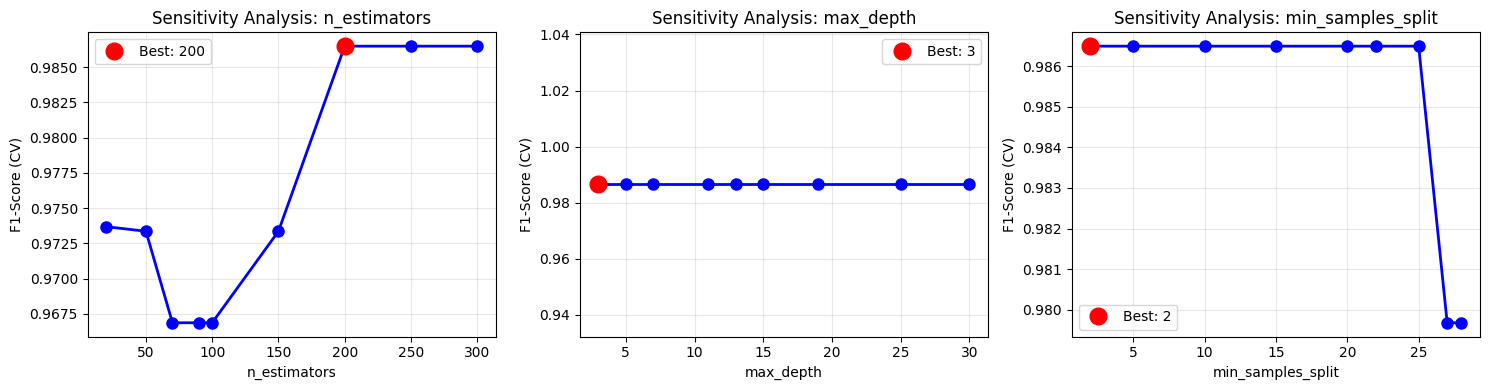

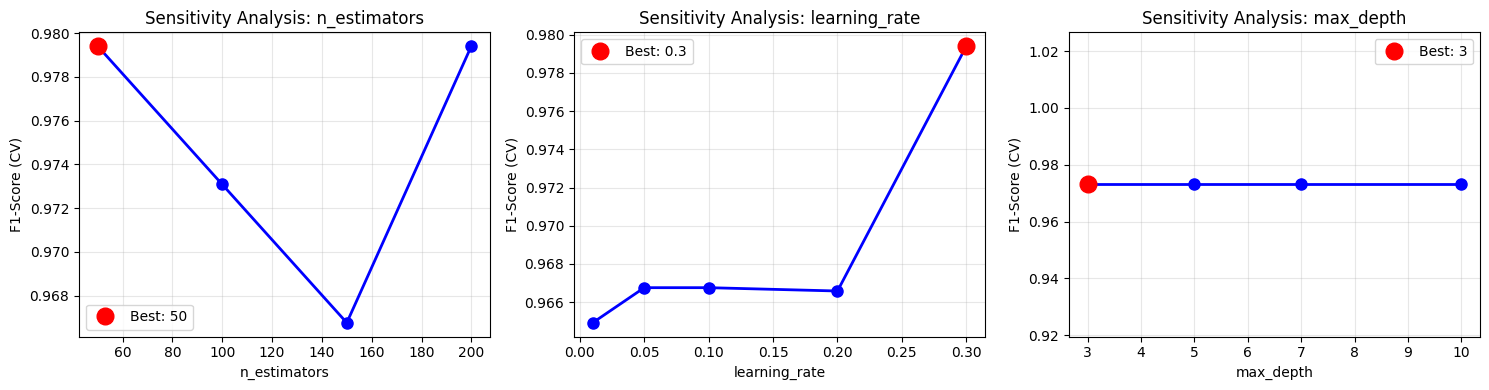

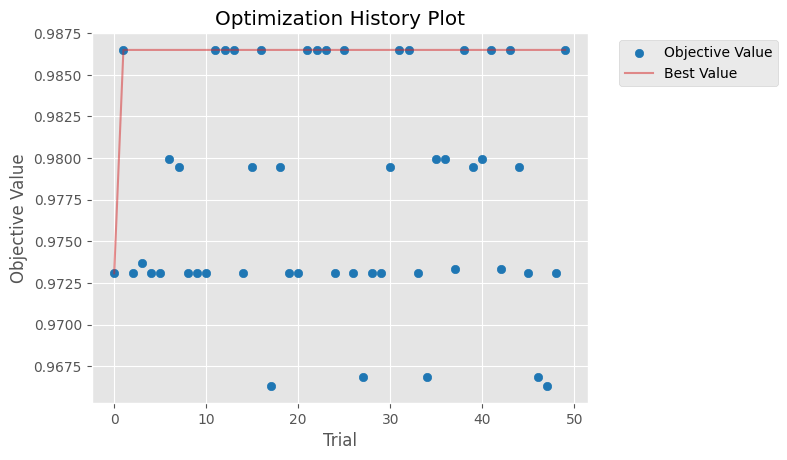

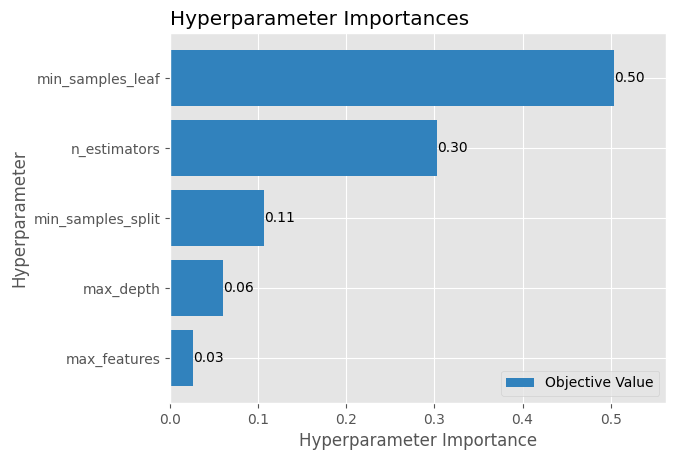

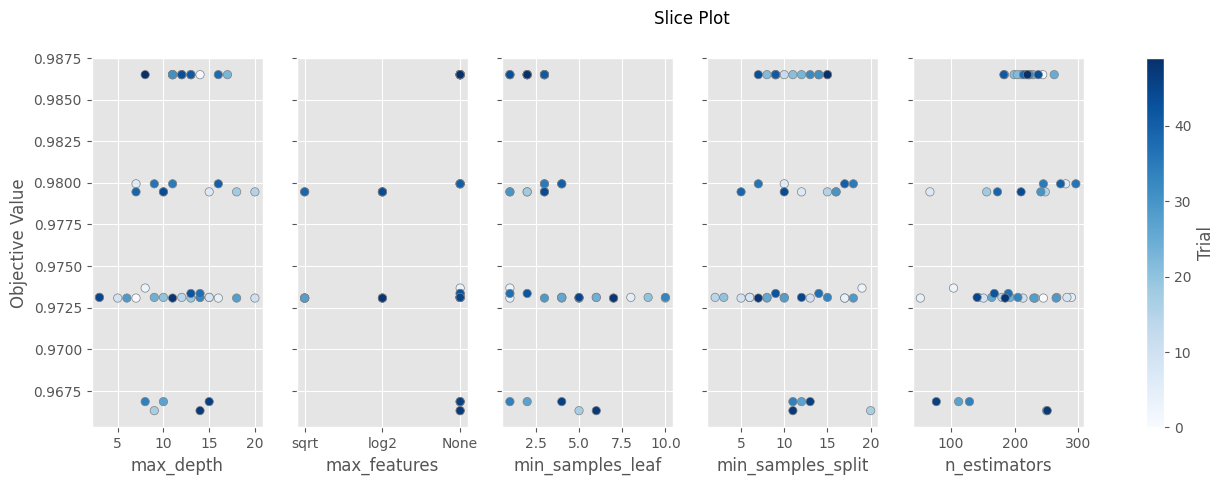

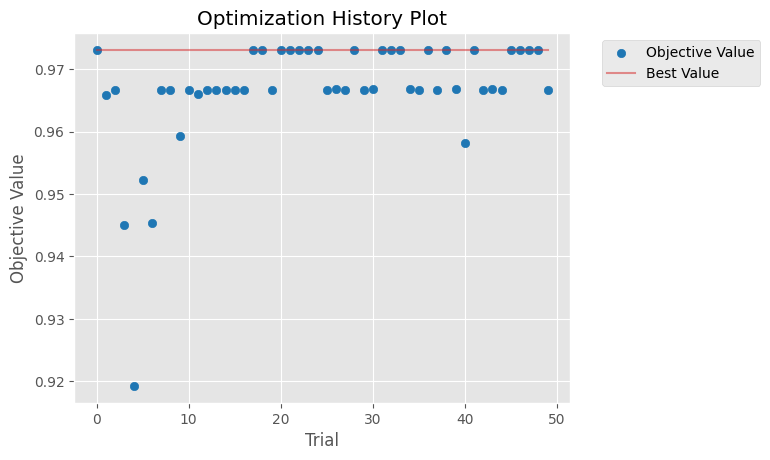

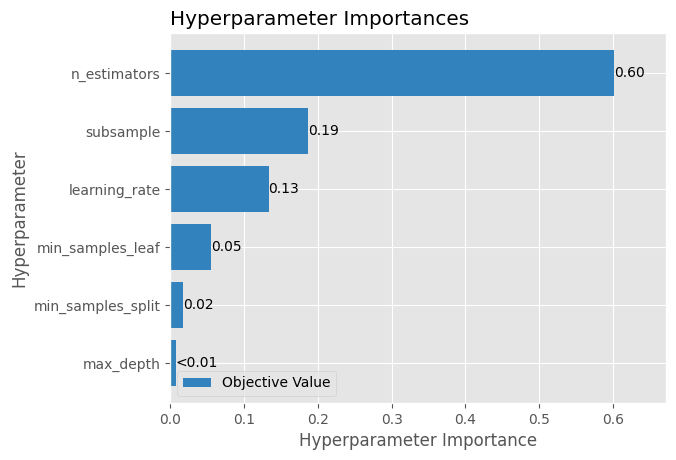

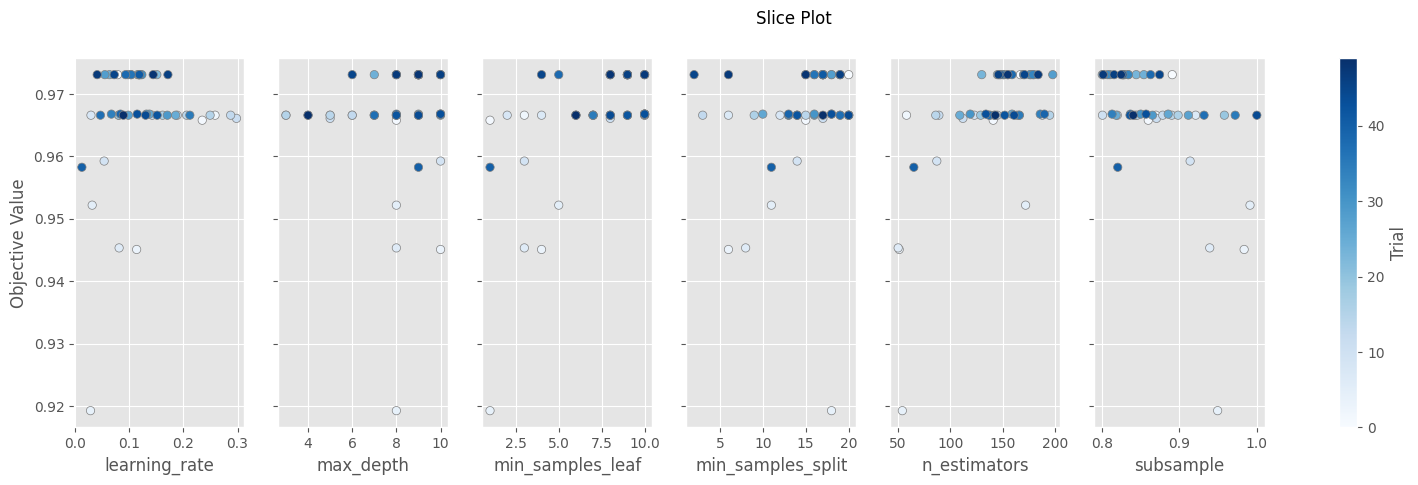

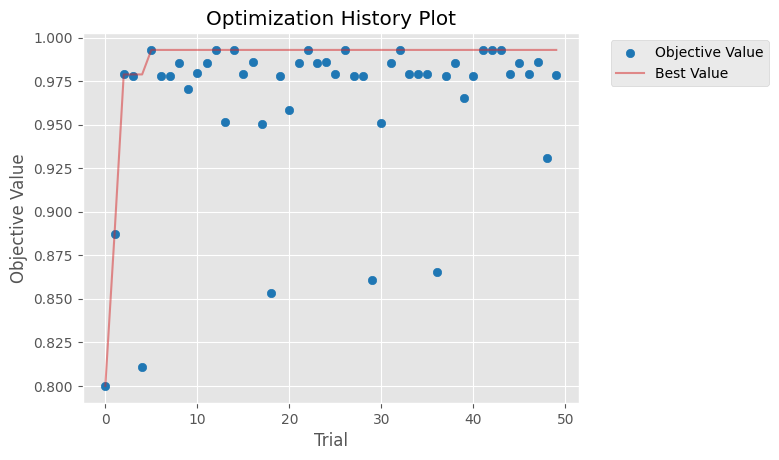

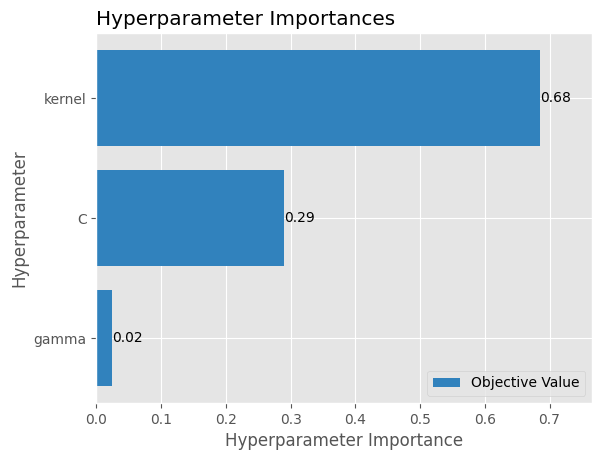

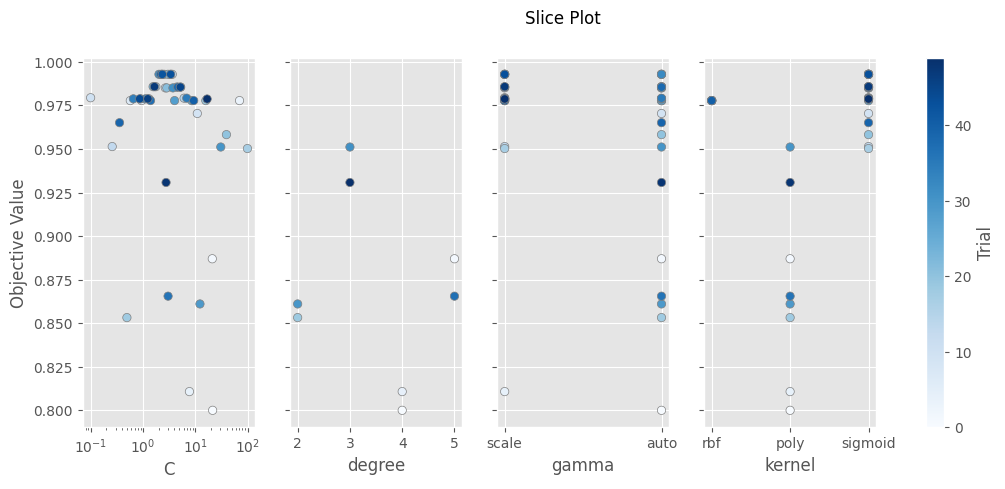


COMPREHENSIVE HYPERPARAMETER SENSITIVITY ANALYSIS REPORT

Dataset Information:
- Training samples: 142
- Test samples: 36
- Features: 13
- Classes: 3

Optimization Summary:

RandomForest:
	Best Score: 0.9865
	Number of trials: 50
	Best parameters: {'n_estimators': 244, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None}

GradientBoosting:
	Best Score: 0.9731
	Number of trials: 50
	Best parameters: {'n_estimators': 167, 'learning_rate': 0.07888695381012456, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 10, 'subsample': 0.8906898494834624}

SVM:
	Best Score: 0.9929
	Number of trials: 50
	Best parameters: {'C': 3.3712161614068448, 'gamma': 'auto', 'kernel': 'sigmoid'}

LogisticRegression:
	Best Score: 0.9866
	Number of trials: 50
	Best parameters: {'penalty': 'elasticnet', 'C': 0.07315940072796523, 'max_iter': 712, 'l1_ratio': 0.2562799493266301}

Model Performance Comparison:

MODEL EVALUATION RESULTS

RandomForest:
  Accuracy: 1.0000
  

In [15]:
if __name__ == "__main__":
    main()